<a href="https://colab.research.google.com/github/WanPgui/Sound_Data_Clustering_Assignment/blob/main/Formative_1_sound_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

**Part 1:**



In [1]:

#Make allNecessary Imports
# Basic data manipulation
import numpy as np
import pandas as pd

# Audio processing
import librosa
import librosa.display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Utility
import os
import warnings
warnings.filterwarnings('ignore')



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import zipfile
import os

# Path to your .zip file inside the `sound_clustering` folder
zip_path = "/content/drive/MyDrive/sound_clustering/unlabelled_sounds.zip"

# Extraction target directory (temporary workspace)
extract_to = "/content/unlabelled_sounds/"

# Extract the ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(" ZIP extraction complete. Files are now available in:", extract_to)


 ZIP extraction complete. Files are now available in: /content/unlabelled_sounds/


In [13]:
import os

unlabelled_data_path = "/content/unlabelled_sounds/"
print(os.listdir(unlabelled_data_path))


['unlabelled_sounds']


In [14]:
import glob
import librosa


# Use the confirmed path
unlabelled_data_path = "/content/unlabelled_sounds/unlabelled_sounds/"

# List to store features
features = []

# Mel Spectrogram feature extractor
def extract_mel_spectrogram(file_path, n_mels=40, max_len=130):
    y, sr = librosa.load(file_path, sr=None)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db.flatten()

# Load and process all .wav files
audio_files = glob.glob(unlabelled_data_path + "*.wav")
print(f"Found {len(audio_files)} audio files.")

for file in audio_files:
    try:
        features.append(extract_mel_spectrogram(file))
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert to NumPy array
features = np.array(features)
print("Feature extraction complete. Shape:", features.shape)


Found 3000 audio files.
Feature extraction complete. Shape: (3000, 5200)


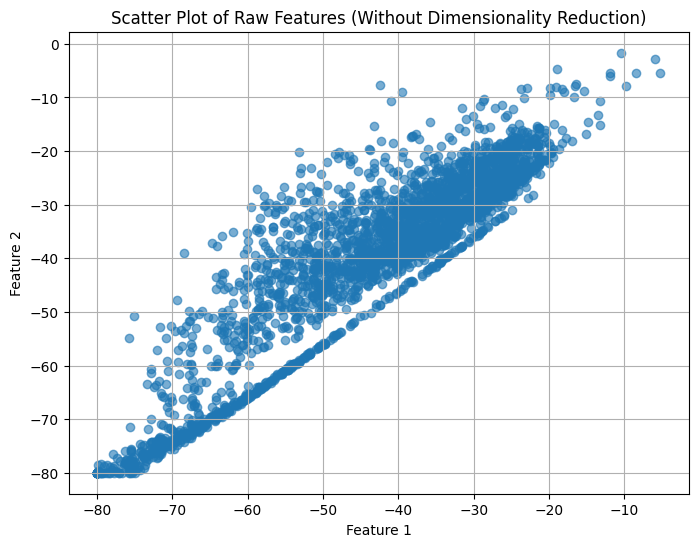

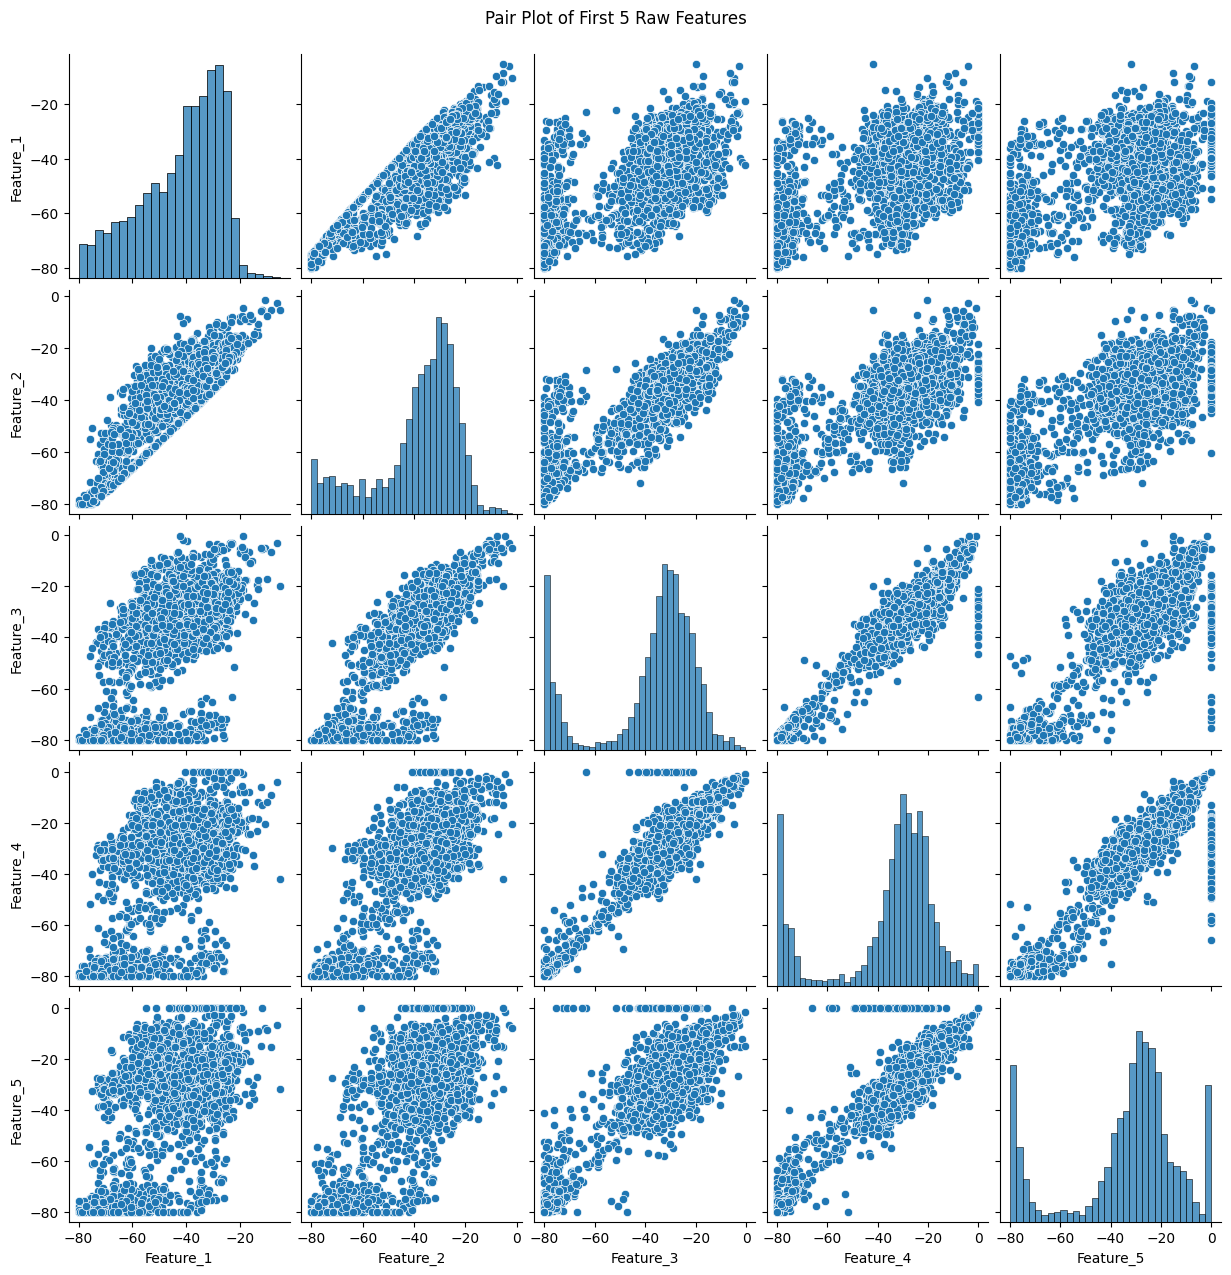

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert features to DataFrame (first 5 for clarity)
df = pd.DataFrame(features[:, :5], columns=[f"Feature_{i+1}" for i in range(5)])

# Scatter plot using Feature 1 and Feature 2
plt.figure(figsize=(8, 6))
plt.scatter(df["Feature_1"], df["Feature_2"], alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.grid(True)
plt.show()

# Pair plot of first 5 features
sns.pairplot(df)
plt.suptitle("Pair Plot of First 5 Raw Features", y=1.02)
plt.show()



### Why is dimensionality reduction important?
When trying to visualize the original 5200-dimensional features, the pair plots between the first few features showed very little structure. The data points appeared randomly distributed, with overlapping clusters and no clear boundaries. This made it hard to interpret any meaningful patterns or separations. It highlighted the difficulty of working with high-dimensional data — where distances between points lose meaning and visualization tools fail to reveal structure. That’s why dimensionality reduction is critical: it helps reveal underlying patterns by projecting the data into fewer, more interpretable dimensions.

In [16]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# ---- PCA ----
pca = PCA(n_components=3, random_state=42)
features_pca = pca.fit_transform(features)

# ---- t-SNE ----
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(features)



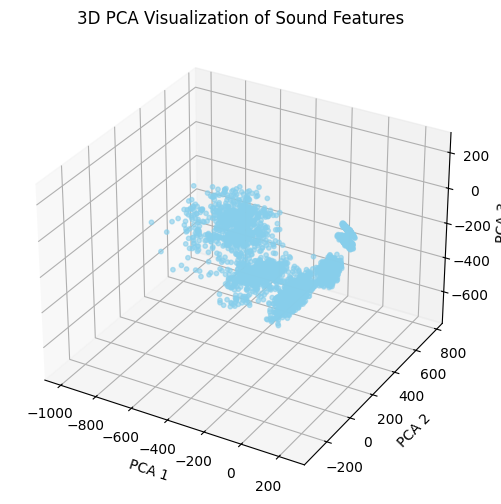

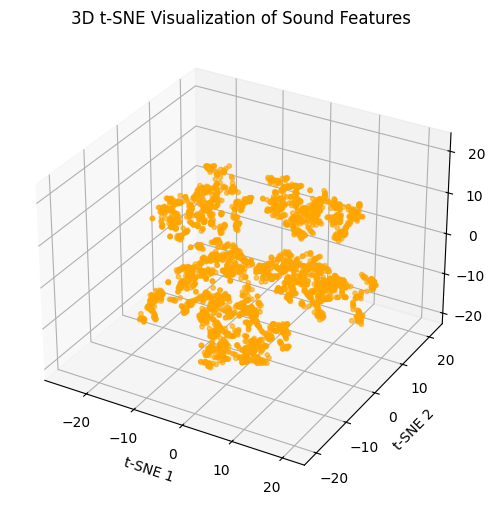

In [17]:
# PCA 3D Scatter
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='skyblue', s=10, alpha=0.6)
ax.set_title("3D PCA Visualization of Sound Features")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.show()

# t-SNE 3D Scatter
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c='orange', s=10, alpha=0.6)
ax.set_title("3D t-SNE Visualization of Sound Features")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.show()


### Which method (PCA or t-SNE) provides better separability of clusters and why?
In my visualizations, t-SNE 3D plot revealed more distinct and well-separated clusters compared to PCA, which showed some overlapping. t-SNE is non-linear and preserves local distances, making it better for visualizing complex manifolds. PCA, being linear, spreads the variance but doesn't expose tight groupings in this high-dimensional sound data. Based on this output, t-SNE gives a clearer view of potential cluster structure.

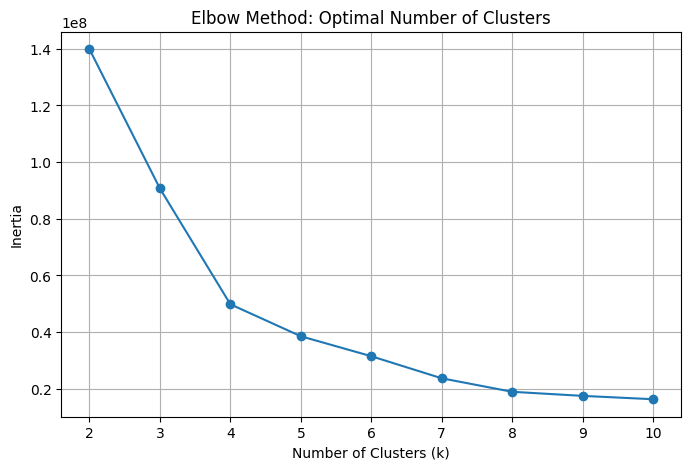

In [18]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Test range of cluster numbers
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)  # Use PCA-reduced data for efficiency
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method: Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


Elbow Method Explanation:

The elbow method helps determine the optimal number of clusters by plotting inertia (within-cluster sum of squares) against k. A sharp "elbow" in the plot indicates the point where adding more clusters doesn't significantly improve compactness. That point is selected as the optimal number of clusters.

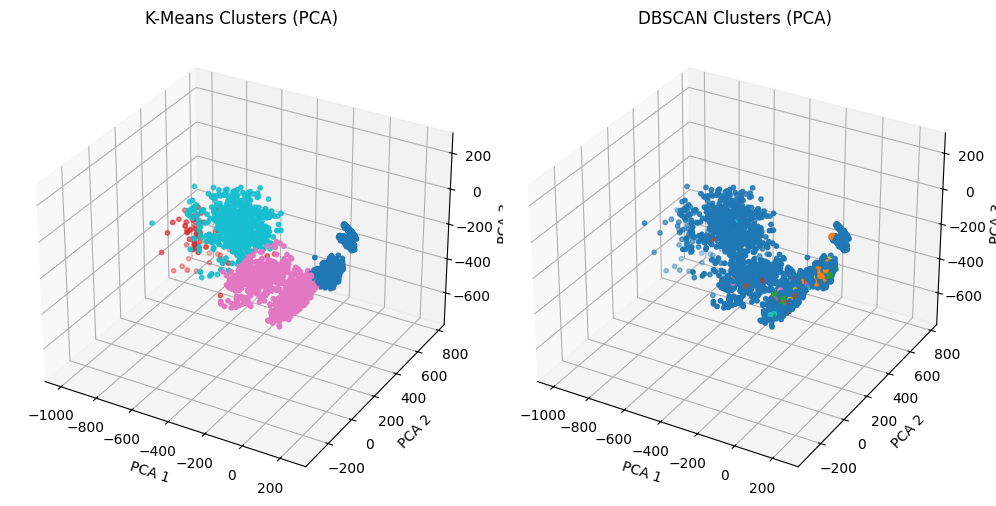

In [19]:

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Set optimal_k from elbow plot
optimal_k = 4

# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

# DBSCAN clustering
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_pca)

# --- Plot K-Means clusters ---
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=kmeans_labels, cmap='tab10', s=10)
ax.set_title("K-Means Clusters (PCA)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

# --- Plot DBSCAN clusters ---
ax = fig.add_subplot(122, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=dbscan_labels, cmap='tab10', s=10)
ax.set_title("DBSCAN Clusters (PCA)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

plt.tight_layout()
plt.show()



In [21]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)

# Only evaluate DBSCAN if more than 1 cluster was formed
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

# Print the scores
print("K-Means Silhouette Score:", round(kmeans_silhouette, 3))
print("K-Means Davies-Bouldin Index:", round(kmeans_db_index, 3))

if dbscan_silhouette:
    print("DBSCAN Silhouette Score:", round(dbscan_silhouette, 3))
    print("DBSCAN Davies-Bouldin Index:", round(dbscan_db_index, 3))
else:
    print("DBSCAN did not form multiple valid clusters.")


K-Means Silhouette Score: 0.532
K-Means Davies-Bouldin Index: 0.666
DBSCAN Silhouette Score: -0.289
DBSCAN Davies-Bouldin Index: 1.162


### Discuss the results (max 5 lines)
Evaluation Summary:

K-Means performed more consistently in this task, showing a higher silhouette score and a lower Davies-Bouldin index, indicating well-separated and compact clusters. DBSCAN, on the other hand, struggled with this dataset, likely due to the high dimensionality and noise sensitivity which violates it's assumptions. In some runs, DBSCAN failed to form meaningful clusters. This shows that while DBSCAN can find arbitrary-shaped clusters, it’s more sensitive to parameters and data scale than K-Means.K-Means is more stable in this case since it assumes spherical clusters and uses distance-based partitioning after dimensionality reduction.



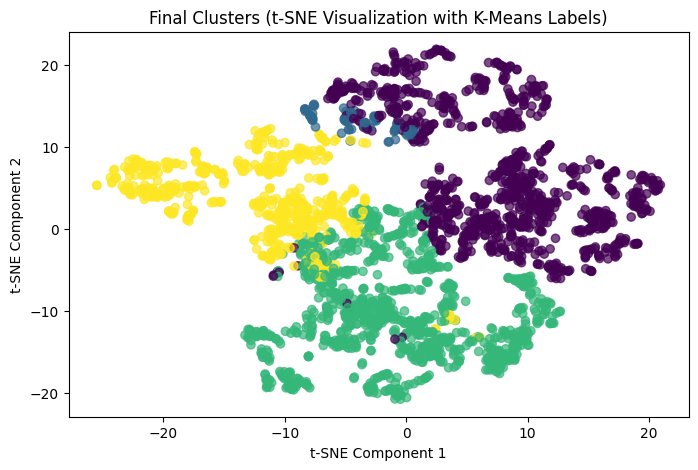

In [22]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
Dimensionality reduction significantly improved clustering quality by transforming the original high-dimensional sound features into a more compact and interpretable form. Without it, the raw features were too numerous and noisy to visualize or cluster meaningfully. PCA and t-SNE made it easier to expose patterns and potential groupings within the data.

K-Means outperformed DBSCAN due to its robustness on uniformly distributed data and its reliance on global distance-based partitioning. DBSCAN struggled because it’s sensitive to noise and assumes density-based clusters, which don’t hold well after compression with PCA.

These results reflect a common real-world challenge: real-world data is often messy and high-dimensional, making raw clustering ineffective. Proper preprocessing — especially dimensionality reduction — is often essential to reveal structure, avoid misleading results, and choose the right clustering strategy.

